edit from fin-ml

In [1]:
import pkg_resources
import pip
installedPackages = {pkg.key for pkg in pkg_resources.working_set}
required = {'nltk', 'spacy', 'textblob', 'backtrader'}
missing = required - installedPackages

In [2]:
#NLP libraries
from textblob import TextBlob
import spacy
import nltk
import warnings
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
import csv
import pandas as pd

import en_core_web_lg
nlp = en_core_web_lg.load()

#Libraries for processing the news headlines
from lxml import etree
import json
from io import StringIO
from os import listdir
from os.path import isfile, join
from pandas.tseries.offsets import BDay
from scipy.stats.mstats import winsorize
from copy import copy

# Libraries for Classification for modeling the sentiments
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Keras package for the deep learning model for the sentiment prediction. 
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Dropout, Activation
from keras.layers.embeddings import Embedding

# Load libraries
import statsmodels.api as sm
import seaborn as sns
import pandas as pd
import numpy as np
import datetime
from datetime import date
import matplotlib.pyplot as plt
import yfinance as yf

#Additional Libraries 
import json  
import zipfile
import os.path
import sys

import tensorflow as tf

#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\juhyeong\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
Using TensorFlow backend.


In [3]:
tf_config = tf.compat.v1.ConfigProto() 
tf_config.gpu_options.allow_growth = True
tf_config.gpu_options.per_process_gpu_memory_fraction = 0.9
tf_config.allow_soft_placement = True

In [4]:
tickers = ['AAPL','MSFT','AMZN','GOOG','FB','WMT','JPM','TSLA','NFLX','ADBE']
start = '2010-01-01'
end = '2018-12-31'
df_ticker_return = pd.DataFrame()
for ticker in tickers:    
    ticker_yf = yf.Ticker(ticker)
    if df_ticker_return.empty:
        df_ticker_return = ticker_yf.history(start = start, end = end)
        df_ticker_return['ticker']= ticker 
    else:
        data_temp = ticker_yf.history(start = start, end = end)
        data_temp['ticker']= ticker 
        df_ticker_return = df_ticker_return.append(data_temp)
df_ticker_return.to_csv(r'./Data/Step2.2_ReturnData.csv')

Let us look at the details of the data

In [5]:
df_ticker_return.head(2)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,ticker
Date,,,,,,,,
2009-12-31,6.58,6.58,6.50,6.5,352410800,0.0,0.0,AAPL
2010-01-04,6.59,6.62,6.55,6.6,493729600,0.0,0.0,AAPL


In [6]:
z = zipfile.ZipFile("./Data/Raw Headline Data.zip", "r")
testFile=z.namelist()[10]
fileData= z.open(testFile).read() 
fileDataSample = json.loads(fileData)['content'][1:500]  

In [7]:
#This function performs the json parsing given the 
def jsonParser(json_data): 
    xml_data = json_data['content']
            
    tree = etree.parse(StringIO(xml_data), parser=etree.HTMLParser())

    headlines = tree.xpath("//h4[contains(@class, 'media-heading')]/a/text()")
    assert len(headlines) == json_data['count']

    main_tickers = list(map(lambda x: x.replace('/symbol/', ''), tree.xpath("//div[contains(@class, 'media-left')]//a/@href")))
    assert len(main_tickers) == json_data['count']
    final_headlines = [''.join(f.xpath('.//text()')) for f in tree.xpath("//div[contains(@class, 'media-body')]/ul/li[1]")]
    if len(final_headlines) == 0:
        final_headlines = [''.join(f.xpath('.//text()')) for f in tree.xpath("//div[contains(@class, 'media-body')]")]
        final_headlines = [f.replace(h, '').split('\xa0')[0].strip() for f,h in zip (final_headlines, headlines)]
    return main_tickers, final_headlines

In [8]:
jsonParser(json.loads(fileData))[1][1]

'Cisco Systems (NASDAQ:CSCO) falls further into the red on FQ4 guidance of $0.37-0.39 vs. $0.42 Street consensus. Sales seen flat to +2% vs. 8% Street view. CSCO recently -2.1%.'

In [9]:
data = None 
data_df_news = []
ret = []
ret_f = []
with zipfile.ZipFile("./Data/Raw Headline Data.zip", "r") as z:
    for filename in z.namelist(): 
        #print(filename)
        try:               
            #print('Running {}'.format(filename))
            with z.open(filename) as f:  
                data = f.read()  
                json_data = json.loads(data)      
            if json_data.get('count', 0)> 10:
                #Step 1: Parse the News Jsons 
                main_tickers, final_headlines = jsonParser(json_data) 
                if len(final_headlines) != json_data['count']:
                    continue
                #Step 2: Prepare Future and Event Return and assign Future and Event return for each ticker. 
                file_date = filename.split('/')[-1].replace('.json', '')
                file_date = date(int(file_date[:4]), int(file_date[5:7]), int(file_date[8:]))
               #Step 3: Merge all the data in a data frame
                df_dict = {'ticker': main_tickers,
                           'headline': final_headlines,            
                           'date': [file_date] * len(main_tickers)
                           }
                df_f = pd.DataFrame(df_dict)            
                data_df_news.append(df_f)            
        except:
            pass  

In [10]:
data_df_news=pd.concat(data_df_news)
data_df_news.head(2)

,ticker,headline,date
0,DVA,Davita (NYSE:DVA): EPS of $0.96 beats by $0.01...,2011-05-02
1,CGNX,Cognex (NASDAQ:CGNX): EPS of $0.32 beats by $0...,2011-05-02


In [11]:
#Computing the return
df_ticker_return['ret_curr'] = df_ticker_return['Close'].pct_change()
#Computing the event return
df_ticker_return['eventRet'] = df_ticker_return['ret_curr'] + df_ticker_return['ret_curr'].shift(-1) + df_ticker_return['ret_curr'].shift(1)
df_ticker_return.reset_index(level=0, inplace=True)
df_ticker_return['date'] = pd.to_datetime(df_ticker_return['Date']).apply(lambda x: x.date())

In [12]:
combinedDataFrame = pd.merge(data_df_news, df_ticker_return, how='left', left_on=['date','ticker'], right_on=['date','ticker'])
combinedDataFrame = combinedDataFrame[combinedDataFrame['ticker'].isin(tickers)]
data_df = combinedDataFrame[['ticker','headline','date','eventRet','Close']]
data_df = data_df.dropna()

In [13]:
data_df.head(2)

,ticker,headline,date,eventRet,Close
5,AMZN,Whole Foods (WFMI) -5.2% following a downgrade...,2011-05-02,0.017650,201.19
11,NFLX,Netflix (NFLX +1.1%) shares post early gains a...,2011-05-02,-0.013003,33.88


In [14]:
data_df.dropna().to_csv(r'./Data/Step3_NewsAndReturnData.csv', sep='|', index=False)

In [15]:
data_df = pd.read_csv(r'./Data/Step3_NewsAndReturnData.csv', sep='|')
data_df = data_df.dropna()

In [16]:
text1 = "Bayer (OTCPK:BAYRY) started the week up 3.5% to €74/share in Frankfurt, touching their \
highest level in 14 months, after the U.S. government said a $25M glyphosate decision against the \
company should be reversed."

In [17]:
data_df['sentiment_textblob'] = [TextBlob(s).sentiment.polarity for s in data_df['headline']] 

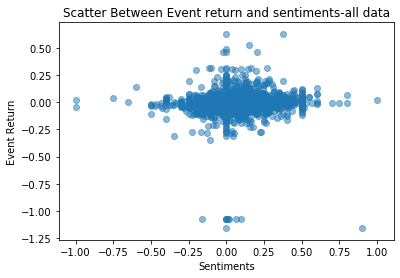

In [18]:
plt.scatter(data_df['sentiment_textblob'],data_df['eventRet'], alpha=0.5)
plt.title('Scatter Between Event return and sentiments-all data')
plt.ylabel('Event Return')
plt.xlabel('Sentiments')
plt.show()

In [19]:
corrlation = data_df['eventRet'].corr(data_df['sentiment_textblob'])
print(corrlation)

0.04273886302307298


The correlation is positive, which means that news with positive sentiments lead to positive return and is expected. However,the correlation isn't very high.  

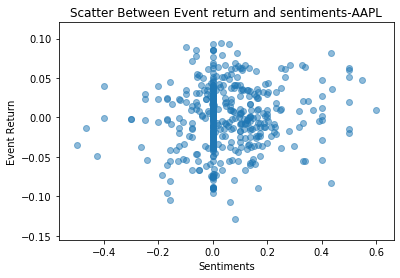

In [20]:
data_df_stock  = data_df[data_df['ticker'] == 'AAPL']
plt.scatter(data_df_stock['sentiment_textblob'],data_df_stock['eventRet'], alpha=0.5)
plt.title('Scatter Between Event return and sentiments-AAPL')
plt.ylabel('Event Return')
plt.xlabel('Sentiments')
plt.show()

Overall, from the results we can see that there isn't a strong correlation between the news and the sentiments. Also, there are a lot of sentiments centred around 0. 

In [21]:
text = "Bayer (OTCPK:BAYRY) started the week up 3.5% to €74/share in Frankfurt, touching their highest level in 14 months, after the U.S. government said a $25M glyphosate decision against the company should be reversed."
TextBlob(text).sentiment_assessments

Sentiment(polarity=0.5, subjectivity=0.5, assessments=[(['touching'], 0.5, 0.5, None)])

In [22]:
sentiments_data = pd.read_csv(r'./Data/LabelledNewsData.csv',encoding = "ISO-8859-1")

In [23]:
sentiments_data.head(1)

,datetime,headline,ticker,sentiment
0,1/16/2020 5:25,$MMM fell on hard times but could be set to re...,MMM,0


In [24]:
print(sentiments_data.shape[0],',', sentiments_data.ticker.unique().shape[0])

9470 , 30


In [25]:
#word-embedding
all_vectors = pd.np.array([pd.np.array([token.vector for token in nlp(s) ]).mean(axis=0)*pd.np.ones((300)) \
                           for s in sentiments_data['headline']])

In [26]:
# split out validation dataset for the end
Y= sentiments_data["sentiment"]
X = all_vectors

from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
validation_size = 0.3
seed = 7
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=validation_size, random_state=seed)

# test options for classification
num_folds = 10
seed = 7
scoring = 'accuracy'

# spot check the algorithms
models = []
models.append(('LR', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('SVM', SVC()))
#Neural Network
models.append(('NN', MLPClassifier()))
#Ensable Models 
models.append(('RF', RandomForestClassifier()))

Running all the classification models

In [27]:
results = []
names = []
kfold_results = []
test_results = []
train_results = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    #msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    #print(msg)
   # Full Training period
    res = model.fit(X_train, Y_train)
    train_result = accuracy_score(res.predict(X_train), Y_train)
    train_results.append(train_result)
    
    # Test results
    test_result = accuracy_score(res.predict(X_test), Y_test)
    test_results.append(test_result)    
    
    msg = "%s: %f (%f) %f %f" % (name, cv_results.mean(), cv_results.std(), train_result, test_result)
    print(msg)
    print(confusion_matrix(res.predict(X_test), Y_test))
    #print(classification_report(res.predict(X_test), Y_test))

LR: 0.881731 (0.008520) 0.896666 0.874340
[[1043  166]
 [ 191 1441]]
KNN: 0.786395 (0.025171) 0.868608 0.787751
[[ 935  304]
 [ 299 1303]]
CART: 0.688941 (0.020093) 0.999698 0.673706
[[ 771  464]
 [ 463 1143]]
SVM: 0.895004 (0.011195) 0.920803 0.897923
[[1088  144]
 [ 146 1463]]
NN: 0.920804 (0.007773) 0.999547 0.935586
[[1135   84]
 [  99 1523]]
RF: 0.814605 (0.023595) 0.999698 0.815558
[[ 861  151]
 [ 373 1456]]


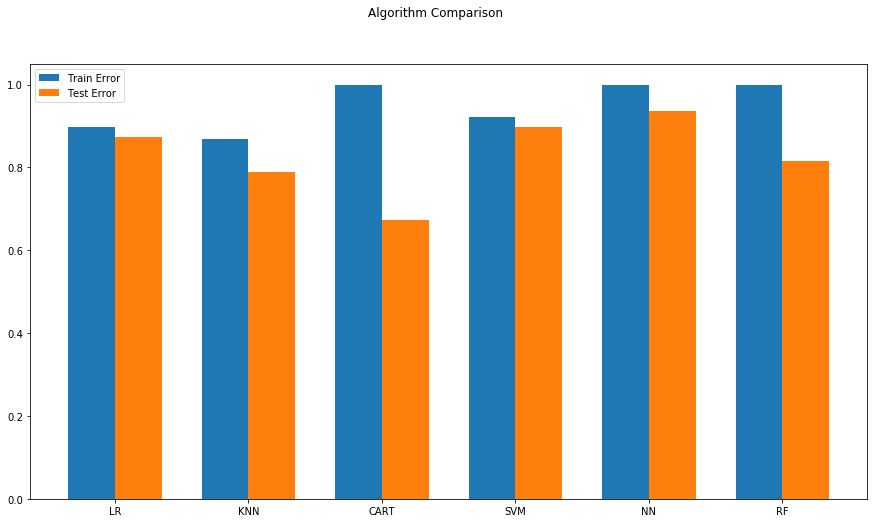

In [28]:
# compare algorithms
from matplotlib import pyplot
fig = pyplot.figure()
ind = np.arange(len(names))  # the x locations for the groups
width = 0.35  # the width of the bars
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, train_results,  width=width, label='Train Error')
pyplot.bar(ind + width/2, test_results, width=width, label='Test Error')
fig.set_size_inches(15,8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
pyplot.show()

In [29]:
### Create sequence
vocabulary_size = 20000
tokenizer = Tokenizer(num_words= vocabulary_size)
tokenizer.fit_on_texts(sentiments_data['headline'])
sequences = tokenizer.texts_to_sequences(sentiments_data['headline'])
X_LSTM = pad_sequences(sequences, maxlen=50)

In [30]:
Y_LSTM = sentiments_data["sentiment"]
X_train_LSTM, X_test_LSTM, Y_train_LSTM, Y_test_LSTM = train_test_split(X_LSTM, \
                       Y_LSTM, test_size=validation_size, random_state=seed)

In [31]:
from keras.wrappers.scikit_learn import KerasClassifier
def create_model(input_length=50):
    model = Sequential()
    model.add(Embedding(20000, 300, input_length=50))
    model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])    
    return model    
model_LSTM = KerasClassifier(build_fn=create_model, epochs=3, verbose=1, validation_split=0.4)
model_LSTM.fit(X_train_LSTM, Y_train_LSTM)

Train on 3977 samples, validate on 2652 samples
Epoch 1/3
3977/3977 [==============================] - 6s 1ms/step - loss: 0.3600 - accuracy: 0.8232 - val_loss: 0.1472 - val_accuracy: 0.9442
Epoch 2/3
3977/3977 [==============================] - 5s 1ms/step - loss: 0.0568 - accuracy: 0.9834 - val_loss: 0.0921 - val_accuracy: 0.9657
Epoch 3/3
3977/3977 [==============================] - 5s 1ms/step - loss: 0.0174 - accuracy: 0.9962 - val_loss: 0.0857 - val_accuracy: 0.9661


In [32]:
train_result_LSTM = accuracy_score(model_LSTM.predict(X_train_LSTM), Y_train_LSTM)
# Test results
test_result_LSTM = accuracy_score(model_LSTM.predict(X_test_LSTM), Y_test_LSTM)

2841/2841 [==============================] - 1s 245us/step


In [33]:
print(train_result_LSTM,test_result_LSTM)

0.9856690300196108 0.9676170362548399


In [34]:
# confusion_matrix(model_LSTM.predict(X_test_LSTM), Y_test_LSTM)

In [35]:
train_results.append(train_result_LSTM);test_results.append(test_result_LSTM)

In [36]:
names.append("LSTM")

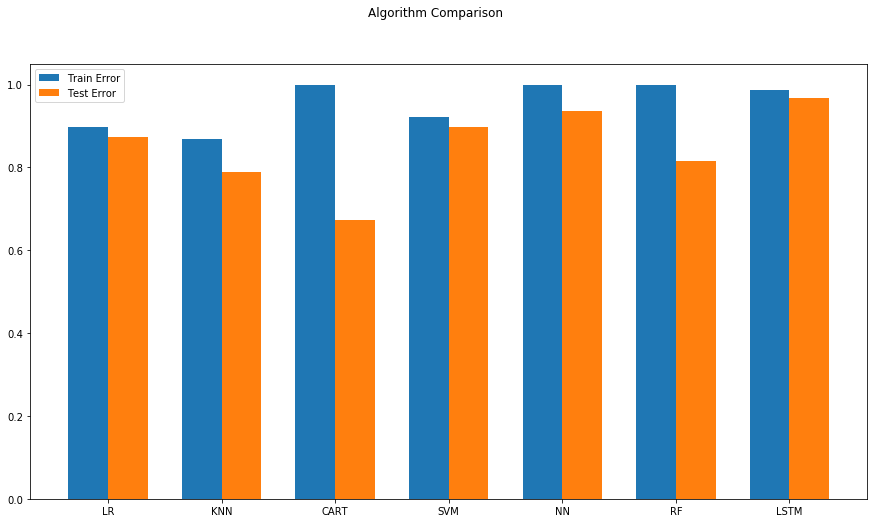

In [37]:
# compare algorithms
from matplotlib import pyplot
fig = pyplot.figure()
ind = np.arange(len(names))  # the x locations for the groups
width = 0.35  # the width of the bars
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, train_results,  width=width, label='Train Error')
pyplot.bar(ind + width/2, test_results, width=width, label='Test Error')
fig.set_size_inches(15,8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
pyplot.show()

In [38]:
sequences_LSTM = tokenizer.texts_to_sequences(data_df['headline'])
X_LSTM = pad_sequences(sequences_LSTM, maxlen=50)

In [39]:
Y_LSTM = model_LSTM.predict(X_LSTM)

2759/2759 [==============================] - 1s 243us/step


In [40]:
data_df['sentiment_LSTM'] = Y_LSTM 

In [41]:
corrlation = data_df['eventRet'].corr(data_df['sentiment_LSTM'])
print(corrlation)

0.07196674798222033


In [42]:
data_df.head(1)

,ticker,headline,date,eventRet,Close,sentiment_textblob,sentiment_LSTM
0,AMZN,Whole Foods (WFMI) -5.2% following a downgrade...,2011-05-02,0.01765,201.19,0.2625,0


In [43]:
# stock market lexicon
sia = SentimentIntensityAnalyzer()
stock_lex = pd.read_csv('./Data/LexiconData.csv')
stock_lex['sentiment'] = (stock_lex['Aff_Score'] + stock_lex['Neg_Score'])/2
stock_lex = dict(zip(stock_lex.Item, stock_lex.sentiment))
stock_lex = {k:v for k,v in stock_lex.items() if len(k.split(' '))==1}
stock_lex_scaled = {}
for k, v in stock_lex.items():
    if v > 0:
        stock_lex_scaled[k] = v / max(stock_lex.values()) * 4
    else:
        stock_lex_scaled[k] = v / min(stock_lex.values()) * -4

final_lex = {}
final_lex.update(stock_lex_scaled)
final_lex.update(sia.lexicon)
sia.lexicon = final_lex

In [44]:
text = "AAPL is trading higher after reporting its October sales rose 12.6% M/M. It has seen a 20%+ jump in orders"

In [45]:
sia.polarity_scores(text)['compound']

0.4535

In [46]:
vader_sentiments = pd.np.array([sia.polarity_scores(s)['compound'] for s in data_df['headline']])

In [47]:
data_df['sentiment_lex'] = vader_sentiments

In [48]:
corrlation = data_df['eventRet'].corr(data_df['sentiment_lex'])

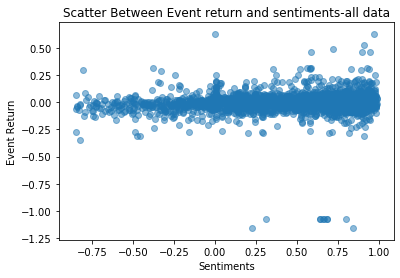

In [49]:
plt.scatter(data_df['sentiment_lex'],data_df['eventRet'], alpha=0.5)
plt.title('Scatter Between Event return and sentiments-all data')
plt.ylabel('Event Return')
plt.xlabel('Sentiments')
plt.show()

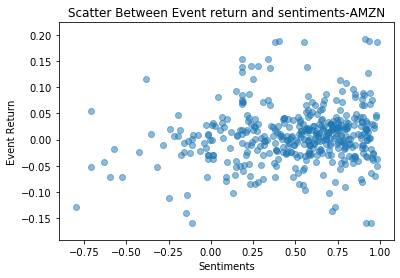

In [50]:
data_df_stock  = data_df[data_df['ticker'] == 'AMZN']
plt.scatter(data_df_stock['sentiment_lex'],data_df_stock['eventRet'], alpha=0.5)
plt.title('Scatter Between Event return and sentiments-AMZN')
plt.ylabel('Event Return')
plt.xlabel('Sentiments')
plt.show()

In [51]:
data_df.to_csv(r'./Data/Step4_DataWithSentimentsResults.csv', sep='|', index=False)

In [52]:
data_df = pd.read_csv(r'Data\Step4_DataWithSentimentsResults.csv', sep='|')
data_df = data_df[data_df['ticker'].isin(tickers)]

In [53]:
data_new_df_stock=data_df[data_df['ticker']== 'NFLX'][['ticker','headline','sentiment_textblob','sentiment_LSTM','sentiment_lex']]
from pandas import option_context

with option_context('display.max_colwidth', 400):
    display(data_new_df_stock.head(1))

,ticker,headline,sentiment_textblob,sentiment_LSTM,sentiment_lex
1,NFLX,"Netflix (NFLX +1.1%) shares post early gains after Citigroup ups its rating to Buy and lifts its price target to $300 from $245. U.S. revenue growth is sustainable, Citi says, ""with a path to 50M subscribers by 2013,"" adding that NFLX has little competition in price, selection and convenience; mass market adoption of tablets will help, and the mass-market adoption phase is still to come.",-0.04375,1,0.8575


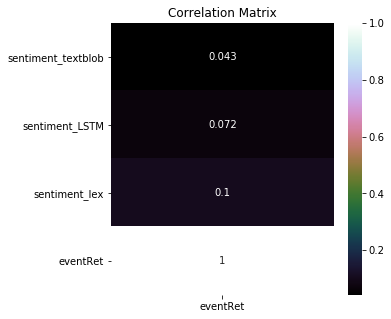

In [54]:
correlation = data_df[['sentiment_textblob','sentiment_LSTM','sentiment_lex','eventRet']].dropna(axis=0).corr()

plt.figure(figsize=(5,5))
plt.title('Correlation Matrix')
sns.heatmap(correlation[['eventRet']], vmax=1, annot=True,cmap='cubehelix')

In [55]:
corr_data = []
for ticker in data_df['ticker'].unique():
    data_new_df_stock=data_df[data_df['ticker']==ticker]
    #Only look for the stocks with sufficient data
    if data_new_df_stock.shape[0] > 40 : 
        corr_textblob= data_new_df_stock['eventRet'].corr(data_new_df_stock['sentiment_textblob'])    
        corr_LSTM = data_new_df_stock['eventRet'].corr(data_new_df_stock['sentiment_LSTM'])
        corr_lex = data_new_df_stock['eventRet'].corr(data_new_df_stock['sentiment_lex'])
        corr_data.append([ticker,corr_textblob, corr_LSTM, corr_lex])
        #print(ticker,corr_vader, corr_LSTM, corr_textblob)
    else:
        continue

In [56]:
corr_df = pd.DataFrame(corr_data, columns =  ['ticker','corr_textblob','corr_LSTM','corr_lex'])  
corr_df=corr_df.set_index('ticker')
corr_df.head(1)

,corr_textblob,corr_LSTM,corr_lex
ticker,,,
AMZN,0.01983,0.075509,0.138073


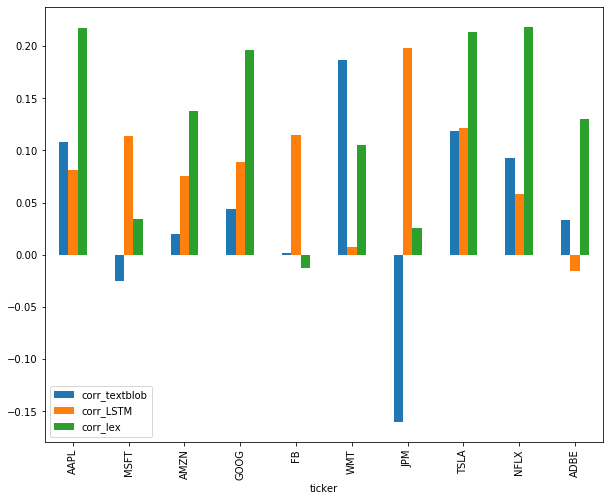

In [57]:
#corr_df.to_csv("correlation.csv")     
#tickers = ['AAPL','MSFT','AMZN','GOOG','BABA','FB','WMT','V','JPM','TSLA']
corr_df.loc[tickers].plot.bar(figsize = (10,8))
plt.show()

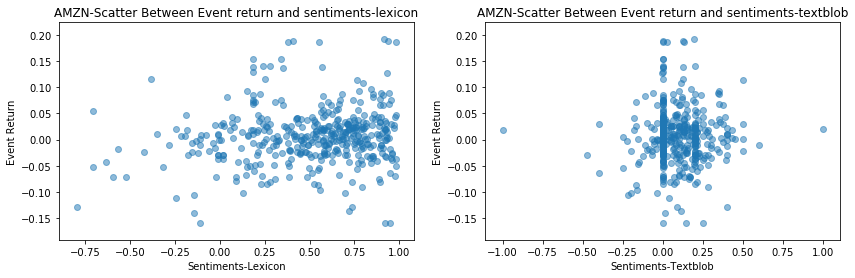

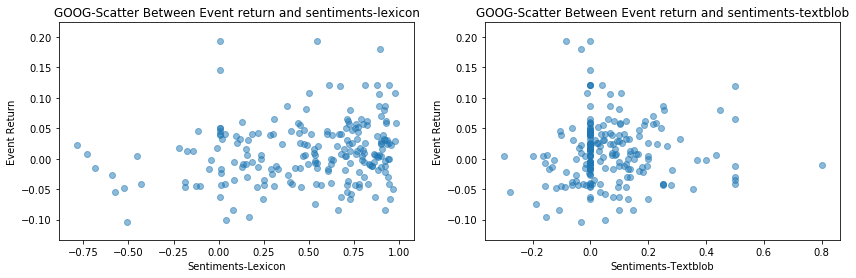

In [58]:
#tickers = corr_df.nlargest(5,'corr_lex').index
for ticker in tickers[2:4]:
    data_df_stock  = data_df[data_df['ticker'] == ticker]
    fig = plt.figure(figsize=(14, 4), constrained_layout=False)

    plt.subplot(1, 2, 1)
    plt.scatter(data_df_stock['sentiment_lex'],data_df_stock['eventRet'], alpha=0.5)
    plt.title(ticker + '-Scatter Between Event return and sentiments-lexicon')
    plt.ylabel('Event Return')
    plt.xlabel('Sentiments-Lexicon')

    
    plt.subplot(1, 2, 2)
    plt.scatter(data_df_stock['sentiment_textblob'],data_df_stock['eventRet'], alpha=0.5)
    plt.title(ticker + '-Scatter Between Event return and sentiments-textblob')
    plt.ylabel('Event Return')
    plt.xlabel('Sentiments-Textblob')
    plt.show()
    

In [59]:
import backtrader as bt
import backtrader.indicators as btind
import backtrader.analyzers as btanalyzers

class Sentiment(bt.Indicator):
    lines = ('sentiment',)
    plotinfo = dict(
        plotymargin=0.5,
        plothlines=[0],
        plotyticks=[1.0, 0, -1.0])
    
    def next(self):
        self.sentiment = 0.0
        self.date = self.data.datetime
        date = bt.num2date(self.date[0]).date()
        prev_sentiment = self.sentiment        
        if date in date_sentiment:
            self.sentiment = date_sentiment[date]
        self.lines.sentiment[0] = self.sentiment


class SentimentStrat(bt.Strategy):
    params = (
        ('period', 15),
        ('printlog', True),
    )

    def log(self, txt, dt=None, doprint=False):
        ''' Logging function for this strategy'''
        if self.params.printlog or doprint:
            dt = dt or self.datas[0].datetime.date(0)
            print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close
        # Keep track of pending orders
        self.order = None
        self.buyprice = None
        self.buycomm = None
        self.sma = bt.indicators.SimpleMovingAverage(
            self.datas[0], period=self.params.period)
        self.date = self.data.datetime
        self.sentiment = None
        Sentiment(self.data)
        self.plotinfo.plot = False
        
        
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return
        
        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))
                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))
                
            self.bar_executed = len(self)     
            
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')
            
        # Write down: no pending order
        self.order = None
        
    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))
    
    ### Main Strat ###
    def next(self):        
        date = bt.num2date(self.date[0]).date()
        prev_sentiment = self.sentiment
        if date in date_sentiment:
            self.sentiment = date_sentiment[date]
        
        # Check if an order is pending. if yes, we cannot send a 2nd one
        if self.order:
            return       
        # If not in the market and previous sentiment not none
        if not self.position and prev_sentiment:
            # buy if current close more than sma AND sentiment increased by >= 0.5
            if self.dataclose[0] > self.sma[0] and self.sentiment - prev_sentiment >= 0.5:
                self.log('Previous Sentiment %.2f, New Sentiment %.2f BUY CREATE, %.2f' % (prev_sentiment, self.sentiment, self.dataclose[0]))                
                self.order = self.buy()
                
        # Already in the market and previous sentiment not none
        elif prev_sentiment:
            # sell if current close less than sma AND sentiment decreased by >= 0.5
            if self.dataclose[0] < self.sma[0] and self.sentiment - prev_sentiment <= -0.5:
                self.log('Previous Sentiment %.2f, New Sentiment %.2f SELL CREATE, %.2f' % (prev_sentiment, self.sentiment, self.dataclose[0]))                
                self.order = self.sell()

    def stop(self):
        self.log('(MA Period %2d) Ending Value %.2f' %
                 (self.params.period, self.broker.getvalue()), doprint=True)   



In [60]:
def run_strategy(ticker, start, end):
    print(ticker)    
    ticker = yf.Ticker(ticker)
    df_ticker = ticker.history(start = start, end = end)
    
    cerebro = bt.Cerebro()
    # Add the data
    cerebro.addstrategy(SentimentStrat)        
    data = bt.feeds.PandasData(dataname=df_ticker)
    cerebro.adddata(data)    
    start = 100000.0
    cerebro.broker.setcash(start)   
    cerebro.addsizer(bt.sizers.FixedSize, stake=100)
    print('Starting Portfolio Value: %.2f' % start)    
    plt.rcParams['figure.figsize']=[10,6]
    plt.rcParams["font.size"]="12"
    cerebro.run() 
    cerebro.plot(volume=False, iplot=True, plotname= ticker)
    end = cerebro.broker.getvalue()
    print('Start Portfolio value: %.2f\nFinal Portfolio Value: %.2f\nProfit: %.2f\n' \
          % (start, end, end - start))
    return float(df_ticker['Close'][0]), (end - start)

GOOG
Starting Portfolio Value: 100000.00
2012-04-12, Previous Sentiment 0.24, New Sentiment 0.80 BUY CREATE, 324.29
2012-04-13, BUY EXECUTED, Price: 322.57, Cost: 32257.00, Comm 0.00
2012-10-18, Previous Sentiment 0.98, New Sentiment 0.08 SELL CREATE, 346.20
2012-10-19, SELL EXECUTED, Price: 351.47, Cost: 32257.00, Comm 0.00
2012-10-19, OPERATION PROFIT, GROSS 2890.00, NET 2890.00
2013-01-10, Previous Sentiment 0.08, New Sentiment 0.80 BUY CREATE, 369.36
2013-01-11, BUY EXECUTED, Price: 369.61, Cost: 36961.00, Comm 0.00
2014-07-17, Previous Sentiment 0.73, New Sentiment -0.22 SELL CREATE, 572.16
2014-07-18, SELL EXECUTED, Price: 591.38, Cost: 36961.00, Comm 0.00
2014-07-18, OPERATION PROFIT, GROSS 22177.00, NET 22177.00
2014-07-18, Previous Sentiment -0.22, New Sentiment 0.77 BUY CREATE, 593.45
2014-07-21, BUY EXECUTED, Price: 590.13, Cost: 59013.00, Comm 0.00
2014-09-12, Previous Sentiment 0.66, New Sentiment -0.05 SELL CREATE, 574.04
2014-09-15, SELL EXECUTED, Price: 571.37, Cost: 59

<IPython.core.display.Javascript object>


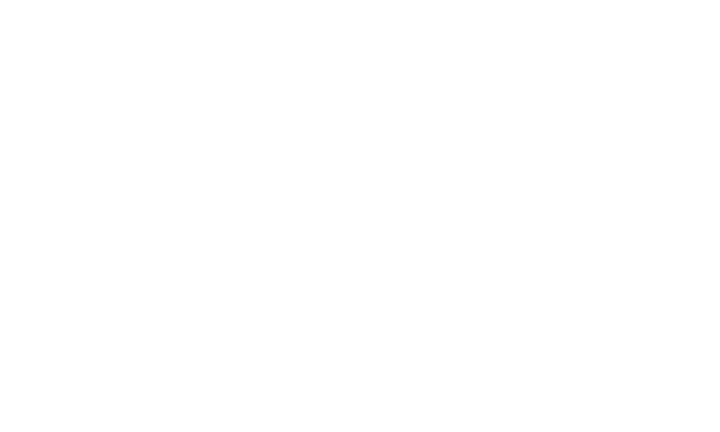

Start Portfolio value: 100000.00
Final Portfolio Value: 149719.00
Profit: 49719.00



(331.46, 49719.0)

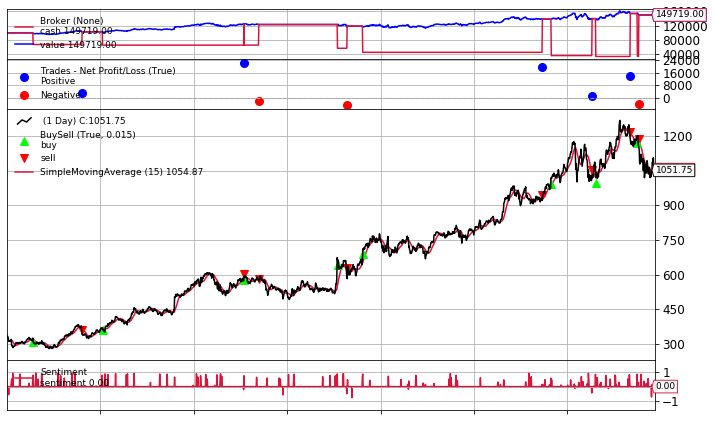

In [61]:
ticker = 'GOOG'
date_sentiment=data_df[data_df['ticker'].isin([ticker])]
date_sentiment=date_sentiment[['date','sentiment_lex']]
date_sentiment['date']=pd.to_datetime(date_sentiment['date'], format='%Y-%m-%d').dt.date
date_sentiment=date_sentiment.set_index('date')['sentiment_lex']
date_sentiment=date_sentiment.to_dict()
run_strategy(ticker, start = '2012-01-01', end = '2018-12-12')

In [62]:
GOOG_ticker= data_df[data_df['ticker'].isin([ticker])]
New= list(GOOG_ticker[GOOG_ticker['date'] ==  '2015-07-17']['headline'])
Old= list(GOOG_ticker[GOOG_ticker['date'] ==  '2015-07-16']['headline'])
print("Current News:",New,"\n\n","Previous News:", Old)

Current News: ["Axiom Securities has upgraded Google (GOOG +13.4%, GOOGL +14.8%) to Buy following the company's Q2 beat and investor-pleasing comments about spending discipline, potential capital returns, and YouTube/mobile growth. MKM has launched coverage at Buy, and plenty of other firms have hiked their targets. Google's market cap is now above $450B."] 

 Previous News: ["While Google's (GOOG, GOOGL) Q2 revenue slightly missed estimates when factoring traffic acquisitions costs (TAC), its ex-TAC revenue of $14.35B was slightly above a $14.3B consensus. The reason: TAC fell to 21% of ad revenue from Q1's 22% and Q2 2014's 23%. That also, of course, helped EPS beat estimates.", 'Google (NASDAQ:GOOG): Q2 EPS of $6.99 beats by $0.28.']


FB
Starting Portfolio Value: 100000.00
2012-11-14, Previous Sentiment -0.82, New Sentiment 0.71 BUY CREATE, 22.36
2012-11-15, BUY EXECUTED, Price: 22.34, Cost: 2234.00, Comm 0.00
2013-03-13, Previous Sentiment 0.95, New Sentiment -0.25 SELL CREATE, 27.08
2013-03-14, SELL EXECUTED, Price: 27.10, Cost: 2234.00, Comm 0.00
2013-03-14, OPERATION PROFIT, GROSS 476.00, NET 476.00
2013-04-10, Previous Sentiment -0.25, New Sentiment 0.94 BUY CREATE, 27.57
2013-04-11, BUY EXECUTED, Price: 27.48, Cost: 2748.00, Comm 0.00
2013-11-18, Previous Sentiment 0.98, New Sentiment 0.40 SELL CREATE, 45.83
2013-11-19, SELL EXECUTED, Price: 46.26, Cost: 2748.00, Comm 0.00
2013-11-19, OPERATION PROFIT, GROSS 1878.00, NET 1878.00
2014-01-30, Previous Sentiment 0.01, New Sentiment 0.82 BUY CREATE, 61.08
2014-01-31, BUY EXECUTED, Price: 60.47, Cost: 6047.00, Comm 0.00
2014-12-16, Previous Sentiment 0.68, New Sentiment -0.39 SELL CREATE, 74.69
2014-12-17, SELL EXECUTED, Price: 75.01, Cost: 6047.00, Comm 0.00
2014-

<IPython.core.display.Javascript object>


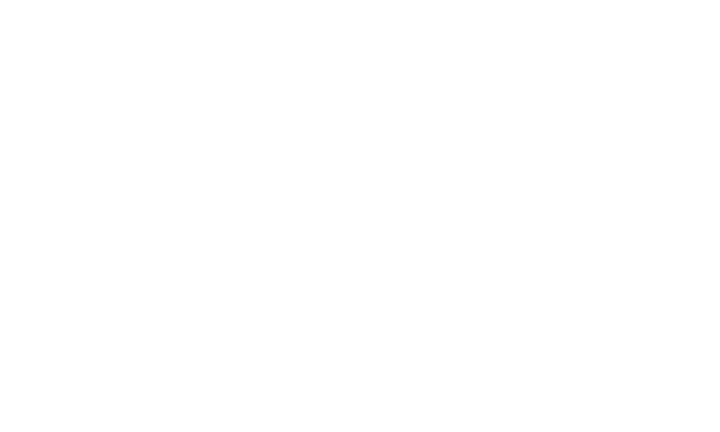

Start Portfolio value: 100000.00
Final Portfolio Value: 108041.00
Profit: 8041.00



(38.23, 8041.0)

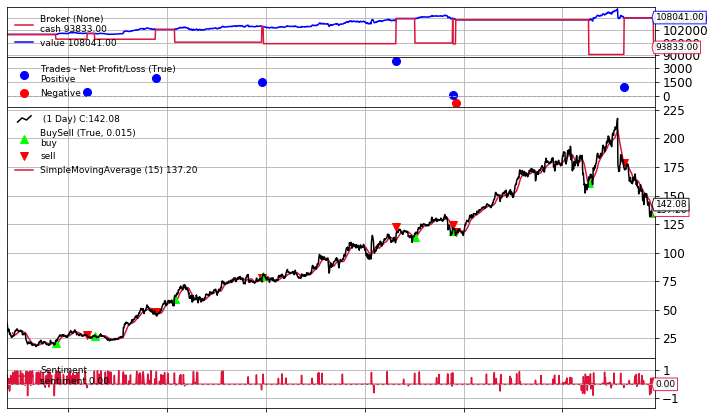

In [63]:
ticker = 'FB'
date_sentiment=data_df[data_df['ticker'].isin([ticker])]
date_sentiment=date_sentiment[['date','sentiment_lex']]
date_sentiment['date']=pd.to_datetime(date_sentiment['date'], format='%Y-%m-%d').dt.date
date_sentiment=date_sentiment.set_index('date')['sentiment_lex']
date_sentiment=date_sentiment.to_dict()
run_strategy(ticker, start = '2012-01-01', end = '2018-12-12')

AAPL
Starting Portfolio Value: 100000.00
2013-12-13, Previous Sentiment -0.38, New Sentiment 0.86 BUY CREATE, 17.70
2013-12-16, BUY EXECUTED, Price: 17.72, Cost: 1772.00, Comm 0.00
2014-09-25, Previous Sentiment 0.78, New Sentiment 0.04 SELL CREATE, 22.23
2014-09-26, SELL EXECUTED, Price: 22.38, Cost: 1772.00, Comm 0.00
2014-09-26, OPERATION PROFIT, GROSS 466.00, NET 466.00
2014-10-21, Previous Sentiment 0.14, New Sentiment 0.68 BUY CREATE, 23.28
2014-10-22, BUY EXECUTED, Price: 23.36, Cost: 2336.00, Comm 0.00
2015-06-11, Previous Sentiment 0.48, New Sentiment -0.42 SELL CREATE, 29.57
2015-06-12, SELL EXECUTED, Price: 29.48, Cost: 2336.00, Comm 0.00
2015-06-12, OPERATION PROFIT, GROSS 612.00, NET 612.00
2015-09-14, Previous Sentiment 0.35, New Sentiment 0.95 BUY CREATE, 26.64
2015-09-15, BUY EXECUTED, Price: 26.78, Cost: 2678.00, Comm 0.00
2015-12-14, Previous Sentiment 0.24, New Sentiment -0.62 SELL CREATE, 26.10
2015-12-15, SELL EXECUTED, Price: 25.97, Cost: 2678.00, Comm 0.00
2015-1

<IPython.core.display.Javascript object>


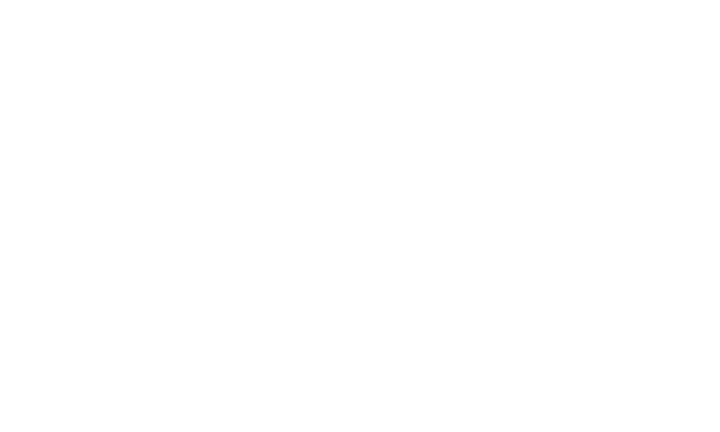

Start Portfolio value: 100000.00
Final Portfolio Value: 100933.00
Profit: 933.00

MSFT
Starting Portfolio Value: 100000.00
2012-03-08, Previous Sentiment -0.50, New Sentiment 0.92 BUY CREATE, 26.37
2012-03-09, BUY EXECUTED, Price: 26.44, Cost: 2644.00, Comm 0.00
2012-04-04, Previous Sentiment 0.87, New Sentiment -0.42 SELL CREATE, 25.71
2012-04-05, SELL EXECUTED, Price: 25.66, Cost: 2644.00, Comm 0.00
2012-04-05, OPERATION PROFIT, GROSS -78.00, NET -78.00
2012-06-19, Previous Sentiment 0.15, New Sentiment 0.88 BUY CREATE, 25.45
2012-06-20, BUY EXECUTED, Price: 25.64, Cost: 2564.00, Comm 0.00
2012-07-12, Previous Sentiment 0.68, New Sentiment -0.65 SELL CREATE, 23.74
2012-07-13, SELL EXECUTED, Price: 23.85, Cost: 2564.00, Comm 0.00
2012-07-13, OPERATION PROFIT, GROSS -179.00, NET -179.00
2012-11-01, Previous Sentiment -0.69, New Sentiment 0.59 BUY CREATE, 24.64
2012-11-02, BUY EXECUTED, Price: 24.70, Cost: 2470.00, Comm 0.00
2012-11-13, Previous Sentiment 0.96, New Sentiment 0.13 SELL C

Start Portfolio value: 100000.00
Final Portfolio Value: 175377.00
Profit: 75377.00

GOOG
Starting Portfolio Value: 100000.00
2012-04-12, Previous Sentiment 0.24, New Sentiment 0.80 BUY CREATE, 324.29
2012-04-13, BUY EXECUTED, Price: 322.57, Cost: 32257.00, Comm 0.00
2012-10-18, Previous Sentiment 0.98, New Sentiment 0.08 SELL CREATE, 346.20
2012-10-19, SELL EXECUTED, Price: 351.47, Cost: 32257.00, Comm 0.00
2012-10-19, OPERATION PROFIT, GROSS 2890.00, NET 2890.00
2013-01-10, Previous Sentiment 0.08, New Sentiment 0.80 BUY CREATE, 369.36
2013-01-11, BUY EXECUTED, Price: 369.61, Cost: 36961.00, Comm 0.00
2014-07-17, Previous Sentiment 0.73, New Sentiment -0.22 SELL CREATE, 572.16
2014-07-18, SELL EXECUTED, Price: 591.38, Cost: 36961.00, Comm 0.00
2014-07-18, OPERATION PROFIT, GROSS 22177.00, NET 22177.00
2014-07-18, Previous Sentiment -0.22, New Sentiment 0.77 BUY CREATE, 593.45
2014-07-21, BUY EXECUTED, Price: 590.13, Cost: 59013.00, Comm 0.00
2014-09-12, Previous Sentiment 0.66, New Se

Start Portfolio value: 100000.00
Final Portfolio Value: 103150.00
Profit: 3150.00

NFLX
Starting Portfolio Value: 100000.00
2012-02-08, Previous Sentiment 0.08, New Sentiment 0.62 BUY CREATE, 17.71
2012-02-09, BUY EXECUTED, Price: 17.77, Cost: 1777.00, Comm 0.00
2012-02-21, Previous Sentiment 0.92, New Sentiment -0.24 SELL CREATE, 16.77
2012-02-22, SELL EXECUTED, Price: 16.42, Cost: 1777.00, Comm 0.00
2012-02-22, OPERATION PROFIT, GROSS -135.00, NET -135.00
2012-03-21, Previous Sentiment 0.10, New Sentiment 0.73 BUY CREATE, 17.16
2012-03-22, BUY EXECUTED, Price: 17.15, Cost: 1715.00, Comm 0.00
2012-05-31, Previous Sentiment 0.92, New Sentiment 0.11 SELL CREATE, 9.06
2012-06-01, SELL EXECUTED, Price: 8.71, Cost: 1715.00, Comm 0.00
2012-06-01, OPERATION PROFIT, GROSS -844.00, NET -844.00
2012-07-03, Previous Sentiment -0.07, New Sentiment 0.85 BUY CREATE, 10.29
2012-07-05, BUY EXECUTED, Price: 10.62, Cost: 1062.00, Comm 0.00
2014-10-15, Previous Sentiment 0.93, New Sentiment -0.02 SELL C

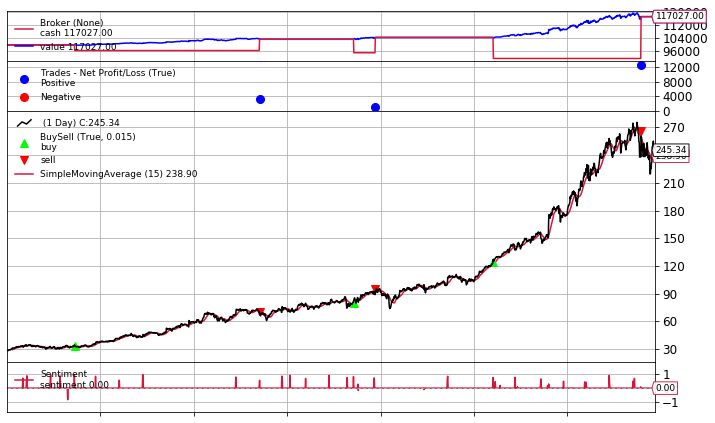

In [64]:
results_tickers = {}
for ticker in tickers:    
    date_sentiment=data_df[data_df['ticker'].isin([ticker])]
    date_sentiment=date_sentiment[['date','sentiment_lex']]
    date_sentiment['date']=pd.to_datetime(date_sentiment['date'], format='%Y-%m-%d').dt.date
    date_sentiment=date_sentiment.set_index('date')['sentiment_lex']
    date_sentiment=date_sentiment.to_dict()
    results_tickers[ticker] = run_strategy(ticker, start = '2012-01-01', end = '2018-12-12')

In [65]:
pd.DataFrame.from_dict(results_tickers).set_index([pd.Index(["PerUnitStartPrice", 'StrategyProfit'])])

,AAPL,MSFT,AMZN,GOOG,FB,WMT,JPM,TSLA,NFLX,ADBE
PerUnitStartPrice,12.69,21.91,179.03,331.46,38.23,48.58,27.31,5.62,10.32,28.57
StrategyProfit,933.00,4059.00,75377.00,49719.00,8041.00,1147.00,2014.00,3150.00,25181.00,17027.00


AAPL
Starting Portfolio Value: 100000.00
2013-12-13, Previous Sentiment -0.38, New Sentiment 0.86 BUY CREATE, 17.70
2013-12-16, BUY EXECUTED, Price: 17.72, Cost: 1772.00, Comm 0.00
2014-09-25, Previous Sentiment 0.78, New Sentiment 0.04 SELL CREATE, 22.23
2014-09-26, SELL EXECUTED, Price: 22.38, Cost: 1772.00, Comm 0.00
2014-09-26, OPERATION PROFIT, GROSS 466.00, NET 466.00
2014-10-21, Previous Sentiment 0.14, New Sentiment 0.68 BUY CREATE, 23.28
2014-10-22, BUY EXECUTED, Price: 23.36, Cost: 2336.00, Comm 0.00
2014-12-30, (MA Period 15) Ending Value 100697.00


<IPython.core.display.Javascript object>


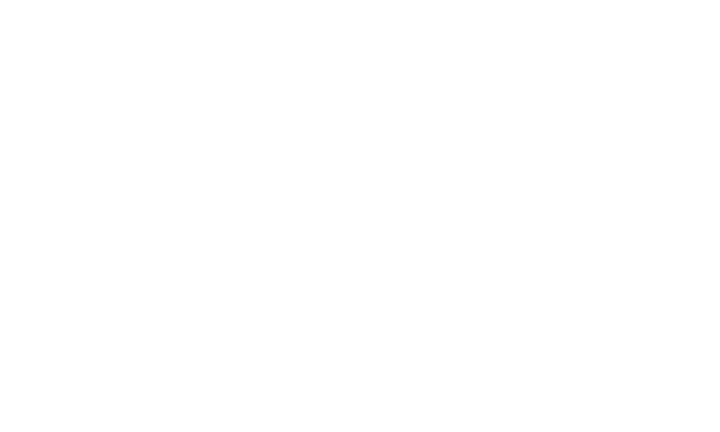

Start Portfolio value: 100000.00
Final Portfolio Value: 100697.00
Profit: 697.00

MSFT
Starting Portfolio Value: 100000.00
2012-03-08, Previous Sentiment -0.50, New Sentiment 0.92 BUY CREATE, 26.37
2012-03-09, BUY EXECUTED, Price: 26.44, Cost: 2644.00, Comm 0.00
2012-04-04, Previous Sentiment 0.87, New Sentiment -0.42 SELL CREATE, 25.71
2012-04-05, SELL EXECUTED, Price: 25.66, Cost: 2644.00, Comm 0.00
2012-04-05, OPERATION PROFIT, GROSS -78.00, NET -78.00
2012-06-19, Previous Sentiment 0.15, New Sentiment 0.88 BUY CREATE, 25.45
2012-06-20, BUY EXECUTED, Price: 25.64, Cost: 2564.00, Comm 0.00
2012-07-12, Previous Sentiment 0.68, New Sentiment -0.65 SELL CREATE, 23.74
2012-07-13, SELL EXECUTED, Price: 23.85, Cost: 2564.00, Comm 0.00
2012-07-13, OPERATION PROFIT, GROSS -179.00, NET -179.00
2012-11-01, Previous Sentiment -0.69, New Sentiment 0.59 BUY CREATE, 24.64
2012-11-02, BUY EXECUTED, Price: 24.70, Cost: 2470.00, Comm 0.00
2012-11-13, Previous Sentiment 0.96, New Sentiment 0.13 SELL C

2014-02-24, Previous Sentiment -0.27, New Sentiment 0.80 BUY CREATE, 43.53
2014-02-25, BUY EXECUTED, Price: 46.00, Cost: 4600.00, Comm 0.00
2014-03-18, Previous Sentiment 0.80, New Sentiment 0.11 SELL CREATE, 48.01
2014-03-19, SELL EXECUTED, Price: 48.28, Cost: 4600.00, Comm 0.00
2014-03-19, OPERATION PROFIT, GROSS 228.00, NET 228.00
2014-06-05, Previous Sentiment -0.08, New Sentiment 0.65 BUY CREATE, 41.38
2014-06-06, BUY EXECUTED, Price: 41.95, Cost: 4195.00, Comm 0.00
2014-07-07, Previous Sentiment 0.86, New Sentiment -0.77 SELL CREATE, 44.53
2014-07-08, SELL EXECUTED, Price: 43.73, Cost: 4195.00, Comm 0.00
2014-07-08, OPERATION PROFIT, GROSS 178.00, NET 178.00
2014-11-20, Previous Sentiment -0.01, New Sentiment 0.69 BUY CREATE, 49.74
2014-11-21, BUY EXECUTED, Price: 50.44, Cost: 5044.00, Comm 0.00
2014-12-01, Previous Sentiment 0.69, New Sentiment -0.33 SELL CREATE, 46.33
2014-12-02, SELL EXECUTED, Price: 46.91, Cost: 5044.00, Comm 0.00
2014-12-02, OPERATION PROFIT, GROSS -353.00, 

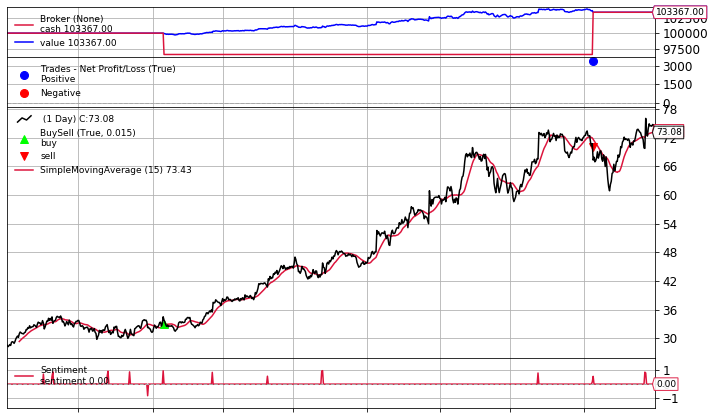

In [66]:
results_tickers = {}
for ticker in tickers:  
    date_sentiment=data_df[data_df['ticker'].isin([ticker])]
    date_sentiment=date_sentiment[['date','sentiment_lex']]
    date_sentiment['date']=pd.to_datetime(date_sentiment['date'], format='%Y-%m-%d').dt.date
    date_sentiment=date_sentiment.set_index('date')['sentiment_lex']
    date_sentiment=date_sentiment.to_dict()
    results_tickers[ticker] = run_strategy(ticker, start = '2012-01-01', end = '2014-12-31')

In [67]:
pd.DataFrame.from_dict(results_tickers).set_index([pd.Index(["StockPriceBeginning", 'StrategyProfit'])])

,AAPL,MSFT,AMZN,GOOG,FB,WMT,JPM,TSLA,NFLX,ADBE
StockPriceBeginning,12.69,21.91,179.03,331.46,38.23,48.58,27.31,5.62,10.32,28.57
StrategyProfit,697.00,617.00,-2873.00,23191.00,3528.00,-311.00,2472.00,2398.00,2712.00,3367.00


AAPL
Starting Portfolio Value: 100000.00
2016-03-15, Previous Sentiment 0.09, New Sentiment 0.66 BUY CREATE, 24.40
2016-03-16, BUY EXECUTED, Price: 24.40, Cost: 2440.00, Comm 0.00
2016-07-26, Previous Sentiment 0.93, New Sentiment 0.14 SELL CREATE, 22.69
2016-07-27, SELL EXECUTED, Price: 24.47, Cost: 2440.00, Comm 0.00
2016-07-27, OPERATION PROFIT, GROSS 7.00, NET 7.00
2016-12-13, Previous Sentiment 0.15, New Sentiment 0.74 BUY CREATE, 27.32
2016-12-14, BUY EXECUTED, Price: 27.29, Cost: 2729.00, Comm 0.00
2017-09-22, Previous Sentiment 0.58, New Sentiment 0.08 SELL CREATE, 36.47
2017-09-25, SELL EXECUTED, Price: 36.02, Cost: 2729.00, Comm 0.00
2017-09-25, OPERATION PROFIT, GROSS 873.00, NET 873.00
2017-11-06, Previous Sentiment 0.14, New Sentiment 0.64 BUY CREATE, 41.84
2017-11-07, BUY EXECUTED, Price: 41.76, Cost: 4176.00, Comm 0.00
2017-12-08, Previous Sentiment 0.57, New Sentiment -0.02 SELL CREATE, 40.82
2017-12-11, SELL EXECUTED, Price: 40.78, Cost: 4176.00, Comm 0.00
2017-12-11, 

<IPython.core.display.Javascript object>


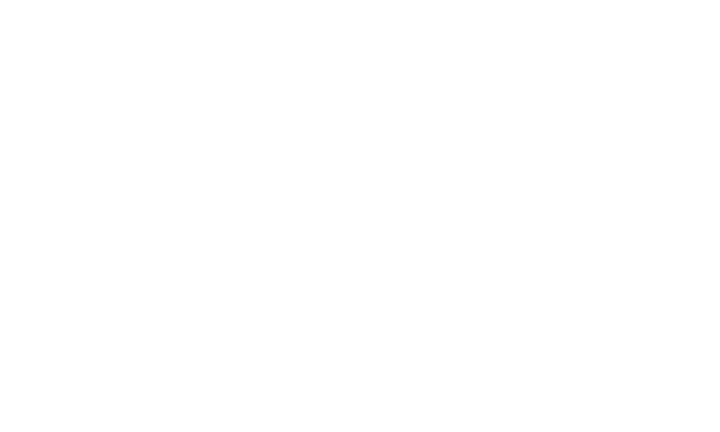

Start Portfolio value: 100000.00
Final Portfolio Value: 99936.00
Profit: -64.00

MSFT
Starting Portfolio Value: 100000.00
2016-01-29, Previous Sentiment 0.01, New Sentiment 0.58 BUY CREATE, 50.40
2016-02-01, BUY EXECUTED, Price: 50.21, Cost: 5021.00, Comm 0.00
2016-02-04, Previous Sentiment 0.58, New Sentiment 0.01 SELL CREATE, 47.58
2016-02-05, SELL EXECUTED, Price: 47.52, Cost: 5021.00, Comm 0.00
2016-02-05, OPERATION PROFIT, GROSS -269.00, NET -269.00
2016-04-21, Previous Sentiment -0.47, New Sentiment 0.90 BUY CREATE, 51.40
2016-04-22, BUY EXECUTED, Price: 47.83, Cost: 4783.00, Comm 0.00
2016-04-28, Previous Sentiment 0.90, New Sentiment 0.01 SELL CREATE, 45.98
2016-04-29, SELL EXECUTED, Price: 45.48, Cost: 4783.00, Comm 0.00
2016-04-29, OPERATION PROFIT, GROSS -235.00, NET -235.00
2017-04-24, Previous Sentiment -0.08, New Sentiment 0.69 BUY CREATE, 63.86
2017-04-25, BUY EXECUTED, Price: 64.21, Cost: 6421.00, Comm 0.00
2017-12-05, Previous Sentiment 0.58, New Sentiment -0.19 SELL C

2018-03-12, Previous Sentiment -0.36, New Sentiment 0.32 BUY CREATE, 69.10
2018-03-13, BUY EXECUTED, Price: 65.72, Cost: 6572.00, Comm 0.00
2018-03-19, Previous Sentiment 0.32, New Sentiment -0.40 SELL CREATE, 62.71
2018-03-20, SELL EXECUTED, Price: 62.97, Cost: 6572.00, Comm 0.00
2018-03-20, OPERATION PROFIT, GROSS -275.00, NET -275.00
2018-06-01, Previous Sentiment -0.60, New Sentiment 0.43 BUY CREATE, 58.36
2018-06-04, BUY EXECUTED, Price: 58.87, Cost: 5887.00, Comm 0.00
2018-07-03, Previous Sentiment 0.75, New Sentiment -0.20 SELL CREATE, 62.17
2018-07-05, SELL EXECUTED, Price: 62.75, Cost: 5887.00, Comm 0.00
2018-07-05, OPERATION PROFIT, GROSS 388.00, NET 388.00
2018-10-23, Previous Sentiment -0.17, New Sentiment 0.39 BUY CREATE, 58.83
2018-10-24, BUY EXECUTED, Price: 60.21, Cost: 6021.00, Comm 0.00
2018-12-28, (MA Period 15) Ending Value 102177.00
Start Portfolio value: 100000.00
Final Portfolio Value: 102177.00
Profit: 2177.00

NFLX
Starting Portfolio Value: 100000.00
2016-05-26

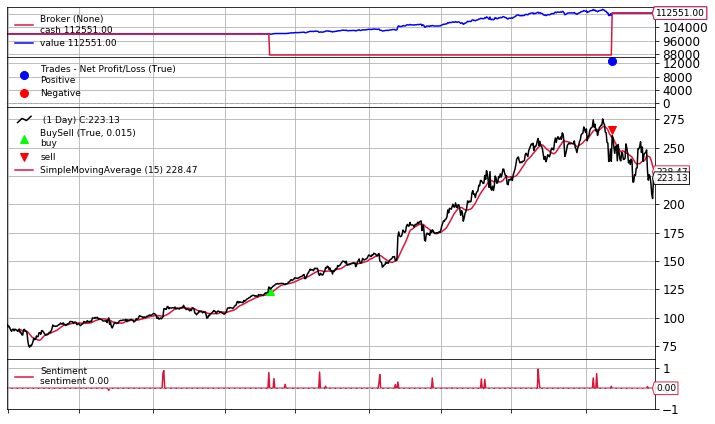

In [68]:
results_tickers = {}
for ticker in tickers: 
    date_sentiment=data_df[data_df['ticker'].isin([ticker])]
    date_sentiment=date_sentiment[['date','sentiment_lex']]
    date_sentiment['date']=pd.to_datetime(date_sentiment['date'], format='%Y-%m-%d').dt.date
    date_sentiment=date_sentiment.set_index('date')['sentiment_lex']
    date_sentiment=date_sentiment.to_dict()
    results_tickers[ticker] = run_strategy(ticker, start = '2016-01-01', end = '2018-12-31')

In [69]:
pd.DataFrame.from_dict(results_tickers).set_index([pd.Index(["PerUnitStartPrice", 'StrategyProfit'])])

,AAPL,MSFT,AMZN,GOOG,FB,WMT,JPM,TSLA,NFLX,ADBE
PerUnitStartPrice,24.42,50.76,675.89,758.88,104.66,54.6,57.56,48.0,114.38,93.94
StrategyProfit,-64.00,3317.00,67454.00,31430.00,648.00,653.0,0.00,2177.0,25020.00,12551.00
